<a href="https://colab.research.google.com/github/romauligraciella/topic-level-sentiment-analysis/blob/main/Topic_Level_Sentiment_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Restart session setelah install
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requ

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/FIX_SKRIPSI/'

Mounted at /content/drive


In [ ]:
# Model Word2Vec
import gensim
w2v_model = gensim.models.Word2Vec.load(path + "w2v-model/w2v-model.bin")

# Model DEC (Xie et. al)
import sys
sys.path.append('/content/drive/MyDrive/FIX_SKRIPSI/')
from DEC import DEC

In [ ]:
import pandas as pd
dataset = pd.read_csv(path + 'Data/dataset_MobileJKN.csv', usecols=['score', 'text_1', 'text_2', 'label'])

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
import joblib
from tqdm import tqdm
import os

def encode_text_bert(input_tokens, data_name, batch_size=128):

    save_dir = path + 'embedding'
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, f'{data_name}_BERT.pkl')

    if os.path.exists(save_path):
        print(f"Loading existing BERT embedding from {save_path}")
        return joblib.load(save_path)

    model = TFAutoModel.from_pretrained('indobenchmark/indobert-base-p2')

    all_outputs = []
    for i in tqdm(range(0, len(input_tokens['input_ids']), batch_size)):
        batch = {k: v[i:i+batch_size] for k, v in input_tokens.items()}
        outputs = model(batch)
        pooled_output = tf.reduce_mean(outputs.last_hidden_state, axis=1)
        all_outputs.append(pooled_output)

    final_output = tf.concat(all_outputs, axis=0)
    joblib.dump(final_output, save_path)
    return final_output

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
tokens = tokenizer(dataset['text_1'].tolist(), return_tensors='tf',
                   truncation=True, padding=True, max_length=128)
emb = encode_text_bert(tokens, 'MobileJKN')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loading existing BERT embedding from /content/drive/MyDrive/FIX_SKRIPSI/embedding/MobileJKN_BERT.pkl


# DEC

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def DAE(data, low_dim):
    vocab_size=data.shape[1]

    # Layer 1
    input_ae = Input(shape = (vocab_size, ))
    dropped_in1 = Dropout(0.2)(input_ae)
    encoded1 = Dense(500, activation = 'relu')(dropped_in1)
    dropped_out1 = Dropout(0.2)(encoded1)
    decoded1 = Dense(vocab_size)(dropped_out1)

    autoencoder1 = Model(input_ae, decoded1)
    encoder1 = Model(input_ae, encoded1)

    # Layer 2
    encoded1_in = Input(shape = (500,))
    dropped_in2 = Dropout(0.2)(encoded1_in)
    encoded2 = Dense(500, activation = 'relu')(dropped_in2)
    dropped_out2 = Dropout(0.2)(encoded2)
    decoded2 = Dense(500, activation = 'relu')(dropped_out2)

    autoencoder2 = Model(encoded1_in,decoded2)
    encoder2 = Model(encoded1_in,encoded2)

    # Layer 3
    encoded2_in = Input(shape = (500,))
    dropped_in3 = Dropout(0.2)(encoded2_in)
    encoded3 = Dense(2000, activation = 'relu')(dropped_in3)
    dropped_out3 = Dropout(0.2)(encoded3)
    decoded3 = Dense(500, activation = 'relu')(dropped_out3)

    autoencoder3 = Model(encoded2_in,decoded3)
    encoder3 = Model(encoded2_in,encoded3)

    # Layer 4
    encoded3_in = Input(shape = (2000,))
    dropped_in4 = Dropout(0.2)(encoded3_in)
    encoded4 = Dense(low_dim)(dropped_in4)
    dropped_out4 = Dropout(0.2)(encoded4)
    decoded4 = Dense(2000, activation = 'relu')(dropped_out4)

    autoencoder4 = Model(encoded3_in,decoded4)
    encoder4 = Model(encoded3_in,encoded4)

    # Deep Autoencoder (𝑑−500−500−2000−10−2000−500−500−𝑑)
    encoder_layer1 = Dense(500, activation='relu')(input_ae)
    encoder_layer2 = Dense(500, activation='relu')(encoder_layer1)
    encoder_layer3 = Dense(2000, activation='relu')(encoder_layer2)
    latent = Dense(low_dim)(encoder_layer3)
    decoder_layer1 = Dense(2000, activation='relu')(latent)
    decoder_layer2 = Dense(500, activation='relu')(decoder_layer1)
    decoder_layer3 = Dense(500, activation='relu')(decoder_layer2)
    output_ae = Dense(vocab_size)(decoder_layer3)

    autoencoder = Model(input_ae,output_ae)
    encoder = Model(input_ae,latent)

    input_dcd = Input(shape=(low_dim,))
    decode_3 = autoencoder.layers[-4](input_dcd)
    decode_2 = autoencoder.layers[-3](decode_3)
    decode_1 = autoencoder.layers[-2](decode_2)
    output_dcd = autoencoder.layers[-1](decode_1)

    decoder = Model(input_dcd, output_dcd)

    cb = []
    opt = 'adam'
    earlystopping = EarlyStopping(monitor ="val_loss", patience = 10, restore_best_weights = True)
    cb.append(earlystopping)

    #compile semua model
    autoencoder1.compile(optimizer=opt, loss='mse')
    autoencoder2.compile(optimizer=opt, loss='mse')
    autoencoder3.compile(optimizer=opt, loss='mse')
    autoencoder4.compile(optimizer=opt, loss='mse')

    autoencoder.compile(optimizer=opt, loss='mse')

    #training
    print('Training layer by layer...\n')
    autoencoder1.fit(data, data, epochs=50, batch_size=256, validation_split = 0.1, callbacks=cb)
    print('1st layer trained.\n')
    first_layer_code = encoder1.predict(data)

    autoencoder2.fit(first_layer_code, first_layer_code, epochs=50, batch_size=256, validation_split = 0.1,
                     callbacks=cb, verbose=1)
    second_layer_code = encoder2.predict(first_layer_code)
    print('2nd layer trained.\n')

    autoencoder3.fit(second_layer_code, second_layer_code, epochs=50, batch_size=256, validation_split = 0.1,
                     callbacks=cb, verbose=1)
    print('3rd layer trained.\n')
    third_layer_code = encoder3.predict(second_layer_code)

    autoencoder4.fit(third_layer_code, third_layer_code, epochs=50, batch_size=256, validation_split = 0.1,
                     callbacks=cb, verbose=1)
    print('4th layer trained.\n')

    autoencoder.layers[1].set_weights(autoencoder1.layers[2].get_weights())
    autoencoder.layers[2].set_weights(autoencoder2.layers[2].get_weights())
    autoencoder.layers[3].set_weights(autoencoder3.layers[2].get_weights())
    autoencoder.layers[4].set_weights(autoencoder4.layers[2].get_weights())
    autoencoder.layers[5].set_weights(autoencoder4.layers[4].get_weights())
    autoencoder.layers[6].set_weights(autoencoder3.layers[4].get_weights())
    autoencoder.layers[7].set_weights(autoencoder2.layers[4].get_weights())
    autoencoder.layers[8].set_weights(autoencoder1.layers[4].get_weights())

    print('Training the whole autoencoder...\n')
    autoencoder_train = autoencoder.fit(data, data, epochs=100, batch_size=256, validation_split = 0.1, callbacks=cb, verbose=1)
    autoencoder_train
    print('Finished.\n')

    return autoencoder, encoder, decoder

# c-TF-IDF

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Class Based TFIDF
def tf_idf_count(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    tf_idf_top_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words, tf_idf_top_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "text": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes

def c_tf_idf(docs_per_topic, m, n_words=10, n_gram_range=(1,1)):
    tf_idf, count = tf_idf_count(docs_per_topic.text.values, m=m)
    #top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, n_words)
    top_words, tf_idf_top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, n_words)
    return tf_idf, count, top_words, tf_idf_top_words

In [ ]:
def run_DEC(data, n_topics, low_dim=10, greedy=True):
  autoencoder, encoder, decoder = DAE(data, low_dim=low_dim)

  dec = DEC(dims=[data.shape[-1],500,500,2000,low_dim],n_clusters=n_topics)
  dec.autoencoder.set_weights(autoencoder.get_weights())
  dec.compile(optimizer='adam', loss='kld')
  y_pred= dec.fit(data, save_dir='.', tol=5e-3)

  return y_pred, dec

# BERT-DEC-cTFIDF

In [ ]:
def BERT_DEC_cTFIDF(df, data_name, n_clusters, n_words=10, n_gram_range=(1,1), greedy=True):

    # BERT
    print('Creating Text Embedding using BERT...')
    emb = encode_text_bert(tokens, data_name='MobileJKN')

    # DEC
    print('Training DEC...')
    y_pred, dec = run_DEC(data=emb, n_topics=n_clusters)

    # cTFIDF
    print('Extracting top words using cTFIDF')
    docs_df = df[['text_2']].copy()
    docs_df.rename({'text_2': 'text'}, axis=1, inplace=True)

    docs_df['topic'] = y_pred.reshape(-1,1)

    docs_df['doc_id'] = range(len(docs_df))

    docs_per_topic = docs_df.dropna(subset=['text']).groupby(['topic'], as_index = False).agg({'text': ' '.join})

    c_tf_idf_, count, top_words, top_words_c_tf_idf = c_tf_idf(docs_per_topic, docs_df.shape[0],
                                                              n_words=n_words, n_gram_range=n_gram_range)

    print('FINISHED')

    return emb, dec, y_pred, c_tf_idf_, count, top_words, top_words_c_tf_idf

# Word2Vec

In [ ]:
# Nilai Coherence
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):

        pair_scores = []
        for i in range(len(term_rankings[topic_index])):
            for j in range(i + 1, len(term_rankings[topic_index])):
                term_i = term_rankings[topic_index][i]
                term_j = term_rankings[topic_index][j]
                if term_i in w2v_model.wv.key_to_index and term_j in w2v_model.wv.key_to_index:
                    pair_scores.append(w2v_model.wv.similarity(term_i, term_j))

        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score

    return overall_coherence / len(term_rankings)

# Simulasi DEC

In [ ]:
import os

tc_w2v = []
best_tc_w2v = 0

for n_topic in range(1, 11):
    temp_file = f'{path}DEC/tc_w2v/temp_tc_w2v_topic{n_topic}.pkl'

    # Cek apakah file sudah ada
    if os.path.exists(temp_file):
        tc_w2v_sim = joblib.load(temp_file)

        if len(tc_w2v_sim) >= 10:
            print(f'SKIPPED: Topic {n_topic} already processed.')
            tc_w2v.append(tc_w2v_sim)

            mean_tc = np.mean(tc_w2v_sim)
            if best_tc_w2v < mean_tc:
                best_tc_w2v = mean_tc
                bests_file = f'{path}DEC/best_dec_topics_ctfidf_count_topwords_topic{n_topic}.pkl'
                best_dec, best_topics, best_c_tf_idf, best_count, best_top_words, best_top_words_ctfidf = joblib.load(bests_file)
                best_n_topic = n_topic
            continue
        else:
            print(f'RESUMING: Topic {n_topic} from simulation {len(tc_w2v_sim)+1}')
    else:
        tc_w2v_sim = []

    print('='*100)
    print('TOPIC:', n_topic)
    best_tc_w2v_sim = max(tc_w2v_sim) if tc_w2v_sim else 0

    # Inisialisasi variabel simpanan terbaik di level per-topic
    best_dec_sim = best_topics_sim = best_c_tf_idf_sim = best_count_sim = None
    best_top_words_sim = best_top_words_ctfidf_sim = None

    for sim in range(len(tc_w2v_sim), 10):
        print('='*100)
        print('SIMULATION:', sim + 1)
        print('='*100)

        emb_, dec_, topics_, c_tf_idf_, count_, top_words_, top_words_c_tf_idf_ = BERT_DEC_cTFIDF(
            dataset, data_name='MobileJKN', n_clusters=n_topic)

        coherence = calculate_coherence(w2v_model, top_words_)
        tc_w2v_sim.append(coherence)

        if best_tc_w2v_sim < coherence:
            best_tc_w2v_sim = coherence
            best_dec_sim = dec_
            best_topics_sim = topics_
            best_c_tf_idf_sim = c_tf_idf_
            best_count_sim = count_
            best_top_words_sim = top_words_
            best_top_words_ctfidf_sim = top_words_c_tf_idf_

        print('='*100)
        print(f'FINISHED; {n_topic} TOPICS; SIMULATION {sim + 1}; TC-W2V {round(coherence, 3)}')
        print(f'BEST CURRENT TC-W2V: {best_tc_w2v_sim}; TOP WORDS: {best_top_words_sim if best_top_words_sim else "-"}')

        joblib.dump(tc_w2v_sim, temp_file)

    # Setelah semua simulasi selesai untuk 1 topik
    tc_w2v.append(tc_w2v_sim)
    mean_tc = np.mean(tc_w2v_sim)

    if best_tc_w2v < mean_tc:
        best_tc_w2v = mean_tc
        best_dec = best_dec_sim
        best_topics = best_topics_sim
        best_c_tf_idf = best_c_tf_idf_sim
        best_count = best_count_sim
        best_top_words = best_top_words_sim
        best_top_words_ctfidf = best_top_words_ctfidf_sim
        best_n_topic = n_topic

        bests = (best_dec, best_topics, best_c_tf_idf, best_count, best_top_words, best_top_words_ctfidf)
        joblib.dump(bests, f'{path}DEC/best_dec_topics_ctfidf_count_topwords_topic{n_topic}.pkl')

    print('-'*100)
    print(f'FINISHED; {n_topic} TOPICS ALL SIMULATION; TC-W2V mean {mean_tc}')
    print(f'BEST N TOPICS: {best_n_topic}; BEST TC-W2V: {best_tc_w2v}; BEST TOP WORDS: {best_top_words}')
    print('-'*100)

    joblib.dump(tc_w2v, f'{path}DEC/tc_w2v/temp_tc_w2v.pkl')

joblib.dump(tc_w2v, path + 'DEC/tc_w2v/simulasi_tc_w2v.pkl')

SKIPPED: Topic 1 already processed.
SKIPPED: Topic 2 already processed.
SKIPPED: Topic 3 already processed.
SKIPPED: Topic 4 already processed.
SKIPPED: Topic 5 already processed.
SKIPPED: Topic 6 already processed.
SKIPPED: Topic 7 already processed.
SKIPPED: Topic 8 already processed.
SKIPPED: Topic 9 already processed.
RESUMING: Topic 10 from simulation 10
TOPIC: 10
SIMULATION: 10
Creating Text Embedding using BERT...
Loading existing BERT embedding from /content/drive/MyDrive/FIX_SKRIPSI/embedding/MobileJKN_BERT.pkl
Training DEC...
Training layer by layer...

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.2524 - val_loss: 0.1024
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1104 - val_loss: 0.0848
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1003 - val_loss: 0.0812
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0967 - val_loss: 0.0763
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0944 - val_loss: 0.0754


['/content/drive/MyDrive/FIX_SKRIPSI/DEC/tc_w2v/simulasi_tc_w2v.pkl']

In [ ]:
import os

tc_w2v = []
best_tc_w2v = 0
for n_topic in range(1, 11):
    print('='*100)
    print('TOPIC:', n_topic)
    tc_w2v_sim = []
    best_tc_w2v_sim = 0
    for sim in range(10):
        print('='*100)
        print('SIMULATION:', sim + 1)
        print('='*100)
        emb_, dec_, topics_, c_tf_idf_, count_, top_words_, top_words_c_tf_idf_ = BERT_DEC_cTFIDF(dataset,
                                                                                                  data_name='MobileJKN',
                                                                                                  n_clusters=n_topic)
        tc_w2v_sim.append(calculate_coherence(w2v_model, top_words_))

        if best_tc_w2v_sim < calculate_coherence(w2v_model, top_words_):
            best_tc_w2v_sim = calculate_coherence(w2v_model, top_words_)

            best_dec_sim, best_topics_sim, best_c_tf_idf_sim, best_count_sim,\
            best_top_words_sim, best_top_words_ctfidf_sim = dec_, topics_, c_tf_idf_, count_, top_words_, top_words_c_tf_idf_

        print('='*100)
        print(f'FINISHED; {n_topic} TOPICS; SIMULATION {sim + 1}; TC-W2V {round(tc_w2v_sim[-1], 3)}')
        print(f'BEST CURRENT TC-W2V: {best_tc_w2v_sim}; TOP WORDS: {best_top_words_sim}')

        # Pastikan folder ada di drive folder
        os.makedirs(path + 'DEC/tc_w2v', exist_ok=True)
        joblib.dump(tc_w2v_sim, f'{path}DEC/tc_w2v/temp_tc_w2v_topic{n_topic}.pkl')

    tc_w2v.append(tc_w2v_sim)

    if best_tc_w2v < np.array(tc_w2v_sim).mean():
        best_tc_w2v = np.array(tc_w2v_sim).mean()

        best_dec, best_topics, best_c_tf_idf, best_count,\
        best_top_words, best_top_words_ctfidf = best_dec_sim, best_topics_sim, best_c_tf_idf_sim, best_count_sim,\
                                                best_top_words_sim, best_top_words_ctfidf_sim
        best_n_topic = n_topic

        bests = (best_dec, best_topics, best_c_tf_idf, best_count, best_top_words, best_top_words_ctfidf)

        joblib.dump(bests, f'{path}DEC/best_dec_topics_ctfidf_count_topwords_topic{n_topic}.pkl')

    print('-'*100)
    print(f'FINISHED; {n_topic} TOPICS ALL SIMULATION; TC-W2V mean {np.array(tc_w2v_sim).mean()}')
    print(f'BEST N TOPICS: {best_n_topic}; BEST TC-W2V: {best_tc_w2v}; BEST TOP WORDS: {best_top_words}')
    print('-'*100)

    # Pastikan folder ada di drive folder
    os.makedirs(path + 'DEC/tc_w2v', exist_ok=True)
    joblib.dump(tc_w2v, f'{path}DEC/tc_w2v/temp_tc_w2v.pkl')

joblib.dump(tc_w2v, path + 'DEC/tc_w2v/simulasi_tc_w2v.pkl')

Streaming output truncated to the last 5000 lines.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0814 - val_loss: 0.0622
Epoch 48/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0813 - val_loss: 0.0625
Epoch 49/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0815 - val_loss: 0.0624
Epoch 50/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0812 - val_loss: 0.0627
1st layer trained.

2777/2777 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0877 - val_loss: 0.0200
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0389 - val_loss: 0.0182
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0369 - val_loss: 0.0176
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0360 - val_loss: 0.0179
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0354 - val_loss: 0.0176
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0350 - val_loss: 0.0176
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━

# Hasil

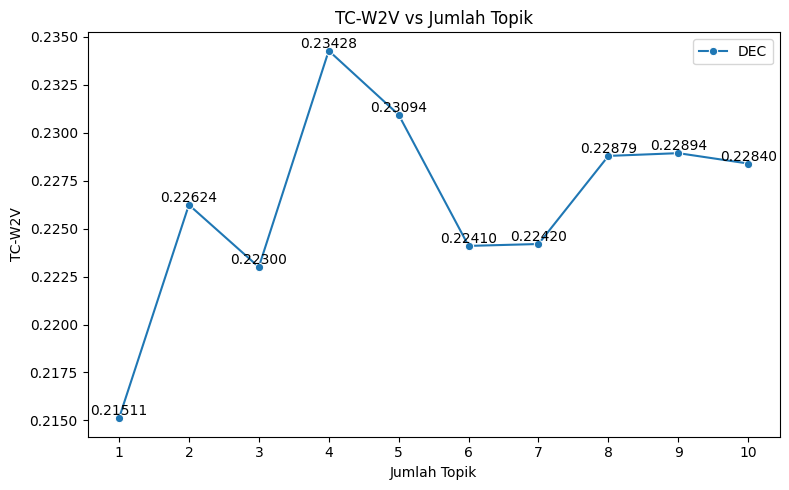

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

tc_w2v_DEC = []
for i in range(1, 11):
  tc_w2v_DEC.append(joblib.load(f'/content/drive/MyDrive/FIX_SKRIPSI/DEC/tc_w2v/temp_tc_w2v_topic{i}.pkl'))

# Define the data
data = {'Jumlah Topik': np.arange(1, 11),
        'TC-W2V DEC': np.array(tc_w2v_DEC).max(axis=1)}

# Create a Seaborn line plot
plt.figure(figsize=(8, 5))
sns.lineplot(x='Jumlah Topik', y='TC-W2V DEC', data=data, marker='o', label='DEC')

# Add text annotations for each data point
for x, y in zip(data['Jumlah Topik'], data['TC-W2V DEC']):
    plt.text(x, y, f'{y:.5f}', ha='center', va='bottom')

# Set the plot title and labels
plt.title('TC-W2V vs Jumlah Topik')
plt.xlabel('Jumlah Topik')
plt.ylabel('TC-W2V')
plt.xticks(np.arange(1, 11), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

# Show the plot
plt.tight_layout()
plt.show()

#tSNE

In [ ]:
bests_4 = joblib.load(f'{path}DEC/best_dec_topics_ctfidf_count_topwords_topic4.pkl')

best_dec_4, best_topics_4, best_c_tf_idf_4, best_count_4, best_top_words_4, best_top_words_ctfidf_4 = bests_4

In [ ]:
calculate_coherence(w2v_model, best_top_words_4)

0.2342790139114691

In [ ]:
enc_dec = best_dec_4.encoder.predict(emb)
enc_dec

2777/2777 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


array([[  2.1203163 ,  -3.7607408 ,  -0.6857841 , ..., -10.921517  ,
         -1.1609493 ,   3.7471437 ],
       [  4.1790004 ,  -3.9239736 ,  -4.084437  , ...,   5.0372586 ,
          1.6069822 ,   2.9009714 ],
       [  4.245367  ,  -3.9713974 ,  -4.1791644 , ...,   5.235418  ,
          1.7046227 ,   2.9145617 ],
       ...,
       [  2.3429718 ,  -4.076551  ,  -0.8779733 , ..., -11.451341  ,
         -0.90256864,   4.0394797 ],
       [ -6.1629357 ,   5.5267673 ,   5.739573  , ...,  -6.548648  ,
          3.8038058 ,  -3.5407224 ],
       [ -5.9517264 ,   5.338764  ,   5.5580244 , ...,  -6.478642  ,
          3.7136111 ,  -3.3939233 ]], dtype=float32)

In [ ]:
cluster_membership = best_dec_4.model.predict(emb, verbose=1).argmax(1)
cluster_membership

2777/2777 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


array([1, 2, 2, ..., 1, 3, 3])

In [ ]:
centroid = best_dec_4.model.get_layer(name='clustering').get_weights()[0]
centroid

array([[ -3.6702373 ,   4.392946  ,   3.974684  ,   1.5538042 ,
          3.3225925 ,   3.2444935 ,   3.0699217 ,   4.7895727 ,
         -5.7421093 ,  -4.493181  ],
       [  2.344525  ,  -4.00973   ,  -0.90772283,  -3.3094747 ,
          3.76489   ,  -0.7871863 ,  -4.6601486 , -11.001741  ,
         -0.98058784,   3.945713  ],
       [  4.2008204 ,  -3.966525  ,  -4.129778  ,   6.6139274 ,
         -4.0471563 ,  -4.5566936 ,   5.675732  ,   4.9736676 ,
          1.7262429 ,   2.9467998 ],
       [ -5.705854  ,   5.1185403 ,   5.333555  , -11.395398  ,
         -1.8805403 ,   5.2746205 ,  -4.5282536 ,  -6.190067  ,
          3.523867  ,  -3.2637987 ]], dtype=float32)

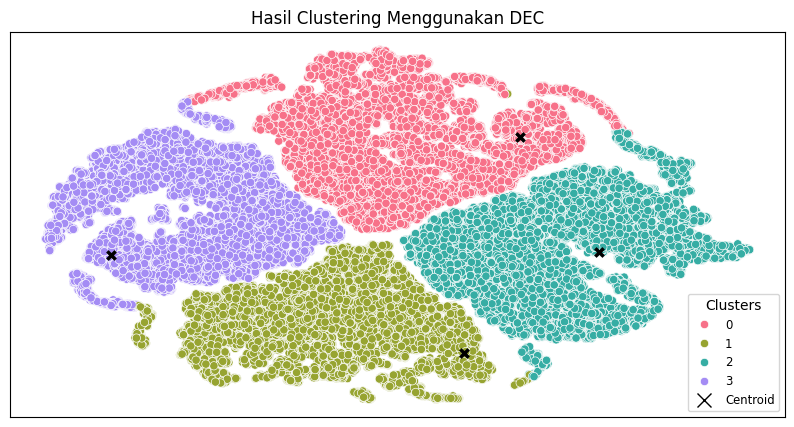

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
unique_values = [0, 1, 2, 3]
# Creating a custom color palette with distinct colors
custom_palette = sns.color_palette("husl", n_colors=len(unique_values))
# Creating a dictionary to map hue values to colors
hue_color_mapping = dict(zip(unique_values, custom_palette))

enc_mobilejkn_tsne = TSNE(2).fit_transform(np.append(enc_dec, centroid, axis=0))

fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x=enc_mobilejkn_tsne[:-4,0], y=enc_mobilejkn_tsne[:-4,1], hue=cluster_membership,
                palette=hue_color_mapping, ax=ax)
sns.scatterplot(x=enc_mobilejkn_tsne[-4:,0], y=enc_mobilejkn_tsne[-4:,1],
                color='black', marker='x', linewidth=2.5, ax=ax)

handles, labels = ax.get_legend_handles_labels()
centroid_marker = mlines.Line2D([], [], color='black', marker='x', linewidth=2.5, linestyle='None', markersize=10, label='Centroid')

handles.append(centroid_marker)
labels.append('Centroid')
ax.legend(handles=handles, labels=labels, title='Clusters', fontsize='small', loc='lower right')

# Hide grid and axes
ax.grid(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.title("Hasil Clustering Menggunakan DEC")
plt.show()

In [ ]:
best_top_words_4

[['update',
  'masuk',
  'login',
  'kode',
  'verifikasi',
  'daftar',
  'susah',
  'aplikasi',
  'otp',
  'buka'],
 ['jkn',
  'mobile',
  'membantu',
  'bpjs',
  'aplikasi',
  'semoga',
  'mudah',
  'pelayanan',
  'mohon',
  'kesehatan'],
 ['daftar',
  'bpjs',
  'aplikasi',
  'pakai',
  'login',
  'nomor',
  'update',
  'masuk',
  'verifikasi',
  'jkn'],
 ['membantu',
  'mudah',
  'bagus',
  'aplikasi',
  'cepat',
  'kesehatan',
  'pelayanan',
  'memudahkan',
  'mempermudah',
  'data']]

In [ ]:
dataset['topik'] = cluster_membership
dataset.to_csv(path+'data_topik_MobileJKN.csv', index=False)

In [ ]:
dataset['topik'].value_counts()

,count
topik,
0,24238
2,23775
3,20706
1,20125


In [ ]:
# Filter data with non-null labels
berlabel = dataset[dataset['label'].notnull()]

# Count the occurrences of each label
label_counts = berlabel['label'].value_counts().sort_index()

# Print the counts
print("Jumlah label 0:", label_counts.get(0.0, 0))
print("Jumlah label 1:", label_counts.get(1.0, 0))


Jumlah label 0: 4442
Jumlah label 1: 4442


In [ ]:
best_dec_4.model.summary()

Model: "functional_467"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_0 (Dense)               │ (None, 500)            │       384,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 2000)           │     1,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 10)             │        20,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clustering (ClusteringLayer)    │ (None, 4)              │            40 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,971,152 (18.96 MB)

 Trainable params: 1,657,050 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,314,102 (12.64 MB)

# Analisis Sentimen

In [ ]:
labelled_idx = dataset['label'].notnull()
emb_labelled = emb[labelled_idx.values]

In [ ]:
emb_labelled

<tf.Tensor: shape=(8884, 768), dtype=float32, numpy=
array([[ 1.0142796 ,  1.4429564 ,  0.5629847 , ...,  1.4831454 ,
        -0.575033  ,  0.6344282 ],
       [ 1.7610829 ,  2.3662863 ,  1.4040964 , ...,  1.3309125 ,
        -0.54275584,  1.1009891 ],
       [ 1.3068691 ,  1.9913292 ,  0.25212744, ...,  0.6771393 ,
        -0.60640323,  0.6694186 ],
       ...,
       [ 0.69462836,  1.8164397 ,  0.9905392 , ...,  1.3306901 ,
        -0.72774065,  0.62107855],
       [ 2.4766157 ,  1.6442615 ,  0.6797583 , ...,  2.48909   ,
        -0.13568418,  1.3965887 ],
       [ 1.3069297 ,  0.6687023 ,  0.31265333, ...,  1.9407028 ,
        -0.2514222 ,  0.39662474]], dtype=float32)>

In [ ]:
# Split data berlabel
from sklearn.model_selection import train_test_split

y_labelled = dataset.loc[labelled_idx, 'label'].reset_index(drop=True)
X_temp, X_test, y_temp, y_test = train_test_split(emb_labelled.numpy(), y_labelled, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [ ]:
import keras
import IPython
import tensorflow as tf

def bert(hp):
    input_token = keras.layers.Input(shape=(emb_labelled.shape[1],), dtype=tf.float32, name="input_layer")

    # Dense layer dengan regularisasi L2
    output = keras.layers.Dense(1,activation='sigmoid',
                                kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values=[1e-2, 1e-3,1e-4])))(input_token)

    model = keras.models.Model(inputs=input_token, outputs=output)

    # Kompilasi model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('lr', [1e-3, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    return model

class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.6 MB/s eta 0:00:00


In [ ]:
import keras_tuner
from keras_tuner import BayesianOptimization

tuner = BayesianOptimization(bert, objective='val_loss', max_trials=10,
                             directory=path + 'BERT-NN', project_name='Sentiment-BERT',
                             overwrite=True)

# Proses pencarian hyperparameter terbaik
tuner.search(X_train, y_train, batch_size=256,
             epochs=50, validation_data=(X_val, y_val),
             callbacks=[early_stop, ClearTrainingOutput()])

Trial 10 Complete [00h 00m 20s]
val_loss: 0.05574207007884979

Best val_loss So Far: 0.05283568799495697
Total elapsed time: 00h 03m 35s


In [ ]:
# Ambil model dan hyperparameter terbaik
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Tampilkan kombinasi parameter terbaik
print("Best hyperparameter combination found:")
print(f" - kernel_dense: {best_hp.get('kernel_dense')}")
print(f" - learning_rate: {best_hp.get('lr')}")

Best hyperparameter combination found:
 - kernel_dense: 0.0001
 - learning_rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8158 - auc_1: 0.9073 - loss: 0.4257 - precision_1: 0.8006 - recall_1: 0.8718 - val_accuracy: 0.9513 - val_auc_1: 0.9863 - val_loss: 0.1723 - val_precision_1: 0.9610 - val_recall_1: 0.9391
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9456 - auc_1: 0.9866 - loss: 0.1686 - precision_1: 0.9728 - recall_1: 0.9166 - val_accuracy: 0.9588 - val_auc_1: 0.9910 - val_loss: 0.1274 - val_precision_1: 0.9664 - val_recall_1: 0.9492
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9518 - auc_1: 0.9897 - loss: 0.1361 - precision_1: 0.9744 - recall_1: 0.9275 - val_accuracy: 0.9650 - val_auc_1: 0.9931 - val_loss: 0.1091 - val_precision_1: 0.9741 - val_recall_1: 0.9543
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9593 - auc_1: 0.9910 - loss: 0.1210 - precision_1: 0.9736 - recall_1: 0.9445 - val_accuracy: 0.9675 - val_auc_1: 0.9944 - val_loss: 0.0982 - val_precision_1: 0.9767 - val_recall_

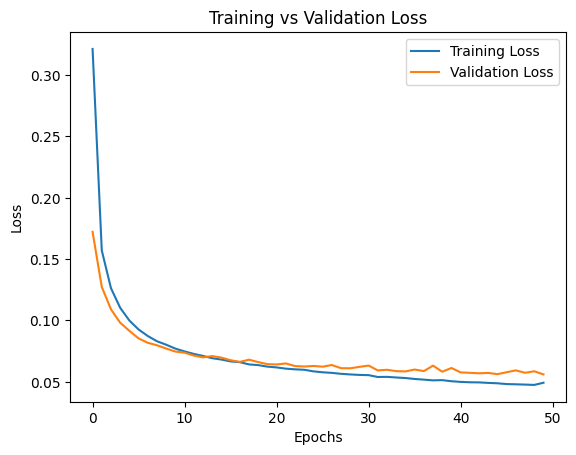

In [ ]:
# Rebuild dan latih ulang dengan hyperparameter terbaik
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         epochs=50, batch_size=256, callbacks=[early_stop])

# Plot val_loss dari training
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


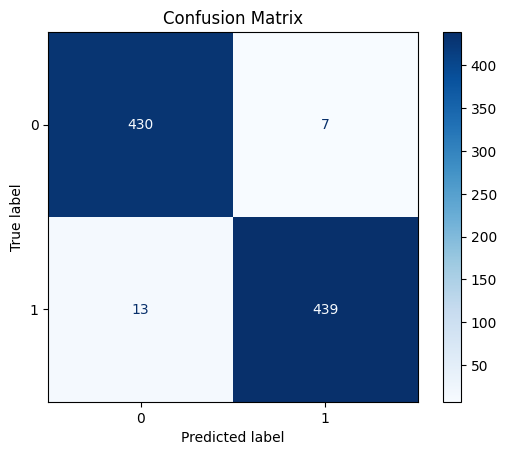

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       437
         1.0       0.98      0.97      0.98       452

    accuracy                           0.98       889
   macro avg       0.98      0.98      0.98       889
weighted avg       0.98      0.98      0.98       889



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))

In [ ]:
print(y_pred.shape)
print(y_test.shape)

(889,)
(889,)


**Deployment**

In [ ]:
unlabelled_idx = dataset['label'].isnull()
emb_unlabelled = emb[unlabelled_idx.values]

In [ ]:
emb_unlabelled

<tf.Tensor: shape=(79960, 768), dtype=float32, numpy=
array([[ 0.5637088 ,  0.8326526 , -0.2515604 , ...,  1.6963998 ,
        -0.47048986,  0.76694   ],
       [ 0.9675842 ,  1.521886  ,  0.02883756, ...,  0.32312602,
        -0.36378238,  0.48386273],
       [ 1.306037  ,  0.8848054 ,  0.34874186, ...,  1.0675657 ,
        -0.55079323,  0.90996844],
       ...,
       [ 0.39445898,  1.4843227 ,  0.8716498 , ...,  1.5788234 ,
        -0.5194606 ,  0.5031302 ],
       [ 1.9371469 ,  1.2696869 ,  0.68423074, ...,  0.9377248 ,
         0.31299022,  1.9828901 ],
       [ 2.0297098 ,  1.2610407 ,  0.8508421 , ...,  2.367771  ,
        -0.00814992,  0.5717964 ]], dtype=float32)>

In [ ]:
# Prediksi label untuk data unlabelled
y_pred_unlabelled_prob = best_model.predict(emb_unlabelled)
y_pred_unlabelled = (y_pred_unlabelled_prob > 0.5).astype("int32")

2499/2499 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [ ]:
y_pred_unlabelled

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
dataset.loc[unlabelled_idx, 'label'] = y_pred_unlabelled

In [ ]:
dataset['label'].unique()

array([1., 0.])

In [ ]:
# Simpan dataset dengan label yang diprediksi
dataset.to_csv(path+'data_sentimen_topik_MobileJKN.csv', index=False)

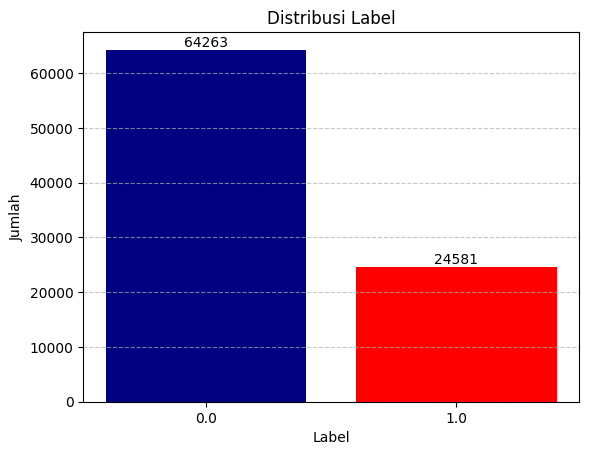

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah masing-masing label
label_counts = dataset['label'].value_counts().sort_index()

# Buat diagram batang
plt.bar(label_counts.index.astype(str), label_counts.values, color=['navy', 'red'])
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Distribusi Label')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan nilai di atas batang
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

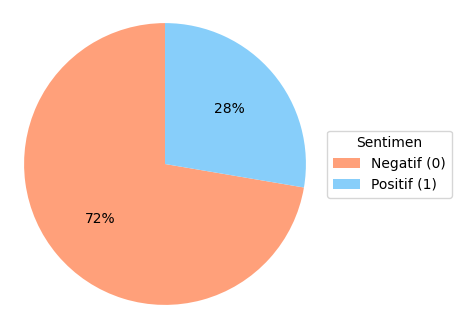

In [ ]:
# prompt: saya ingin buat pie chart utk dataset['label] dimana nilai persentase di buletin aja trs ada di dalam bagiannya lalu warna nya kalau 0 itu negatif merah, kalau 1 itu positif biru untuk warna tulisannya hitam aja bisakah buat warna soft aja grafiknya jd merah dan biru soft

# Hitung jumlah masing-masing label
label_counts = dataset['label'].value_counts().sort_index()

# Buat data untuk pie chart
labels = ['Negatif (0)', 'Positif (1)']
sizes = [label_counts.get(0.0, 0), label_counts.get(1.0, 0)]  # Pastikan menggunakan .get() untuk menangani kasus jika salah satu label tidak ada
colors = ['lightsalmon', 'lightskyblue']  # Warna soft merah dan biru
textcolors = ['black', 'black']

# Buat pie chart
fig1, ax1 = plt.subplots(figsize=(4, 4))
wedges, texts, autotexts = ax1.pie(sizes, colors=colors, autopct='%1.0f%%',
                                   startangle=90, textprops=dict(color="black"))

# Lengkapi pie chart
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(wedges, labels,
           title="Sentimen",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))

# Set warna teks persentase
for autotext in autotexts:
    autotext.set_color('black')

plt.show()


In [ ]:
topics_interpret = []

# Format top words untuk setiap topik
for topic_idx, top_words in enumerate(best_top_words_4):
    topics_interpret.append(f'Topic {topic_idx + 1}: {", ".join(top_words)}')

# Menampilkan interpretasi topik
for topic in topics_interpret:
    print(topic)

# Membuat DataFrame untuk menyusun topik dan kata-kata yang terkait
df_plot = pd.DataFrame({'Topic': [f'Topic {i+1}' for i in range(len(best_top_words_4))], 'Top Words': best_top_words_4})

# Menampilkan DataFrame yang terstruktur
print("\nDataFrame yang menampilkan topik dan kata-kata utama:")
print(df_plot)

Topic 1: update, masuk, login, kode, verifikasi, daftar, susah, aplikasi, otp, buka
Topic 2: jkn, mobile, membantu, bpjs, aplikasi, semoga, mudah, pelayanan, mohon, kesehatan
Topic 3: daftar, bpjs, aplikasi, pakai, login, nomor, update, masuk, verifikasi, jkn
Topic 4: membantu, mudah, bagus, aplikasi, cepat, kesehatan, pelayanan, memudahkan, mempermudah, data

DataFrame yang menampilkan topik dan kata-kata utama:
     Topic                                          Top Words
0  Topic 1  [update, masuk, login, kode, verifikasi, dafta...
1  Topic 2  [jkn, mobile, membantu, bpjs, aplikasi, semoga...
2  Topic 3  [daftar, bpjs, aplikasi, pakai, login, nomor, ...
3  Topic 4  [membantu, mudah, bagus, aplikasi, cepat, kese...


Hasil top words diinterpretasikan dengan GPT

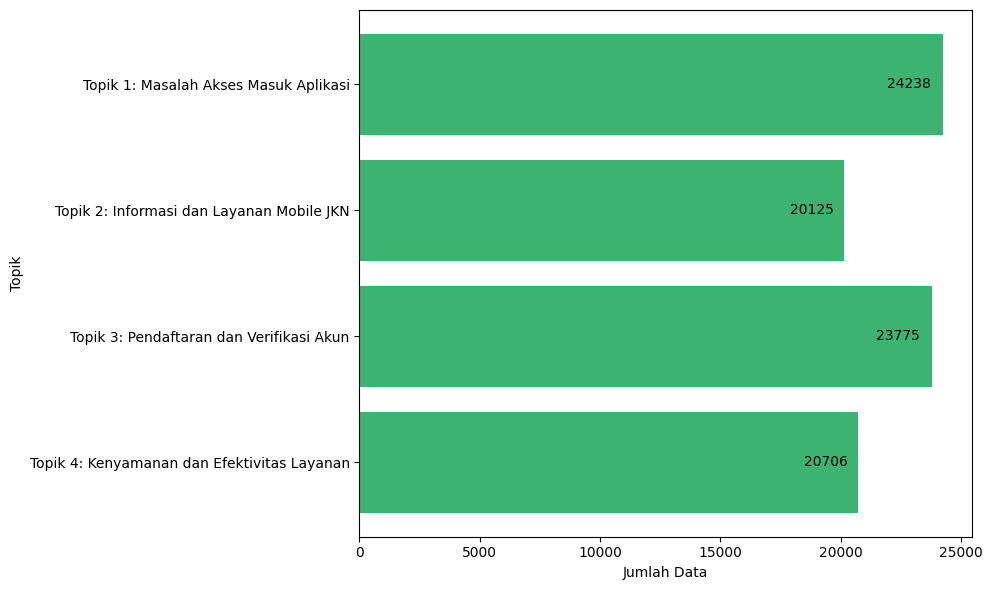

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Contoh: dataset sudah ada
# dataset = pd.read_csv("namafile.csv")

# Nama topik
topic_names = {
    0: "Topik 1: Masalah Akses Masuk Aplikasi",
    1: "Topik 2: Informasi dan Layanan Mobile JKN",
    2: "Topik 3: Pendaftaran dan Verifikasi Akun",
    3: "Topik 4: Kenyamanan dan Efektivitas Layanan"
}

# Hitung jumlah data per topik dan urutkan berdasarkan indeks
topic_counts = dataset['topik'].value_counts().sort_index()

# Ambil label dan nilai, lalu balik urutannya
topic_labels = [topic_names[i] for i in topic_counts.index][::-1]
topic_sizes = topic_counts.values[::-1]

# Buat grafik batang horizontal
plt.figure(figsize=(10, 6))
bars = plt.barh(topic_labels, topic_sizes, color='mediumseagreen')

# Tambahkan nilai di dalam batang (warna putih)
for bar in bars:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    text_x = width * 0.98
    plt.text(text_x, y_pos, str(int(width)),
             va='center', ha='right',
             color='black', fontsize=10)

plt.xlabel('Jumlah Data')
plt.ylabel('Topik')
plt.tight_layout()
plt.show()


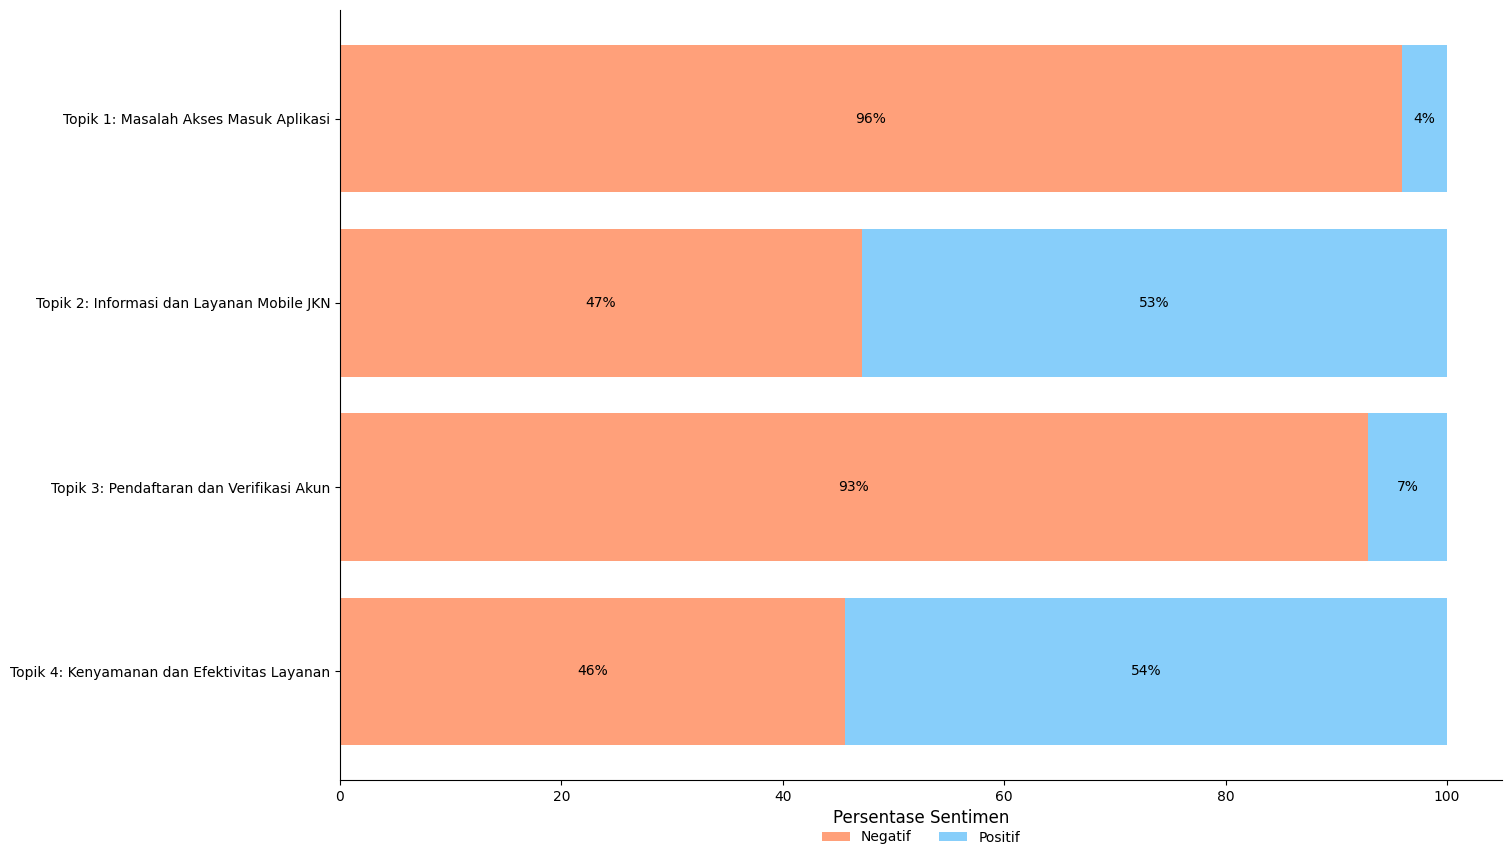

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

topic_sentiment_counts = dataset.groupby(['topik', 'label']).size().unstack(fill_value=0)
topic_sentiment_percentages = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0) * 100

topics_interpret = [
    "Topik 1: Masalah Akses Masuk Aplikasi",
    "Topik 2: Informasi dan Layanan Mobile JKN",
    "Topik 3: Pendaftaran dan Verifikasi Akun",
    "Topik 4: Kenyamanan dan Efektivitas Layanan"
]

# Restructure data for stacked bar chart
df_plot = pd.DataFrame({'topics': topics_interpret}).reset_index(drop=True)

for i in range(df_plot.shape[0]):
    sentiment_percent = dataset.query(f'topik == {i}')['label'].value_counts(normalize=False)
    df_plot.loc[i, sentiment_percent.index] = sentiment_percent.values

df_plot = df_plot.rename({0: 'Negatif', 1: 'Positif'}, axis=1)

# Calculate percentages for stacked bars
total = df_plot['Negatif'] + df_plot['Positif']
df_plot['Neg_%'] = df_plot['Negatif'] / total * 100
df_plot['Pos_%'] = df_plot['Positif'] / total * 100

# Create the stacked bar chart
topics = df_plot['topics'].values
neg = df_plot['Neg_%'].values
pos = df_plot['Pos_%'].values
y = np.arange(len(topics))

fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(y, neg, color='lightsalmon', label='Negatif'),
ax.barh(y, pos, left=neg, color='lightskyblue', label='Positif')

# Add percentage annotations
for i in range(len(topics)):
    ax.text(neg[i] / 2, i, f"{neg[i]:.0f}%", va='center', ha='center', color='black')
    ax.text(neg[i] + pos[i] / 2, i, f"{pos[i]:.0f}%", va='center', ha='center', color='black')

# Customize the chart
ax.set_yticks(y)
ax.set_yticklabels(topics, fontsize=10)
ax.invert_yaxis()  # Invert y-axis to display topics in order
ax.set_xlabel('Persentase Sentimen', fontsize=12)
ax.spines['top'].set_visible(False)  # Remove top spine
ax.spines['right'].set_visible(False)  # Remove right spine
ax.legend(loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.1))


plt.show()